# Recommandation de livres

## installation des modules

!pip install scikit-surprise

## import des modules

In [379]:
import os

import random
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import missingno

from collections import defaultdict
import pickle
from pathlib import Path
from operator import itemgetter

import sklearn
import sklearn.model_selection
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity

from surprise import NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV
from surprise import KNNWithMeans, SVD
from surprise import accuracy

#Settings
pd.set_option('display.max_columns', None)
sns.set(color_codes=True)

#To be avoided in your notebook.
import warnings
warnings.filterwarnings("ignore")

In [293]:
[print(x) for x in os.listdir()];

.ipynb_checkpoints
analysis_recommandation.ipynb
articles_embeddings.pickle
articles_metadata.csv
clicks
clicks.csv
clicks_sample.csv
cosine_similarities.npy
df.csv
pickle_surprise_model_KNNWithMeans.pkl


# Exploratory Data Analysis

## EDA sur fichier "articles_metadata.csv"

In [294]:
PATH_ARTICLES_DATA = "articles_metadata.csv"
articles_df = pd.read_csv(PATH_ARTICLES_DATA)

In [295]:
articles_df.head()


,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162


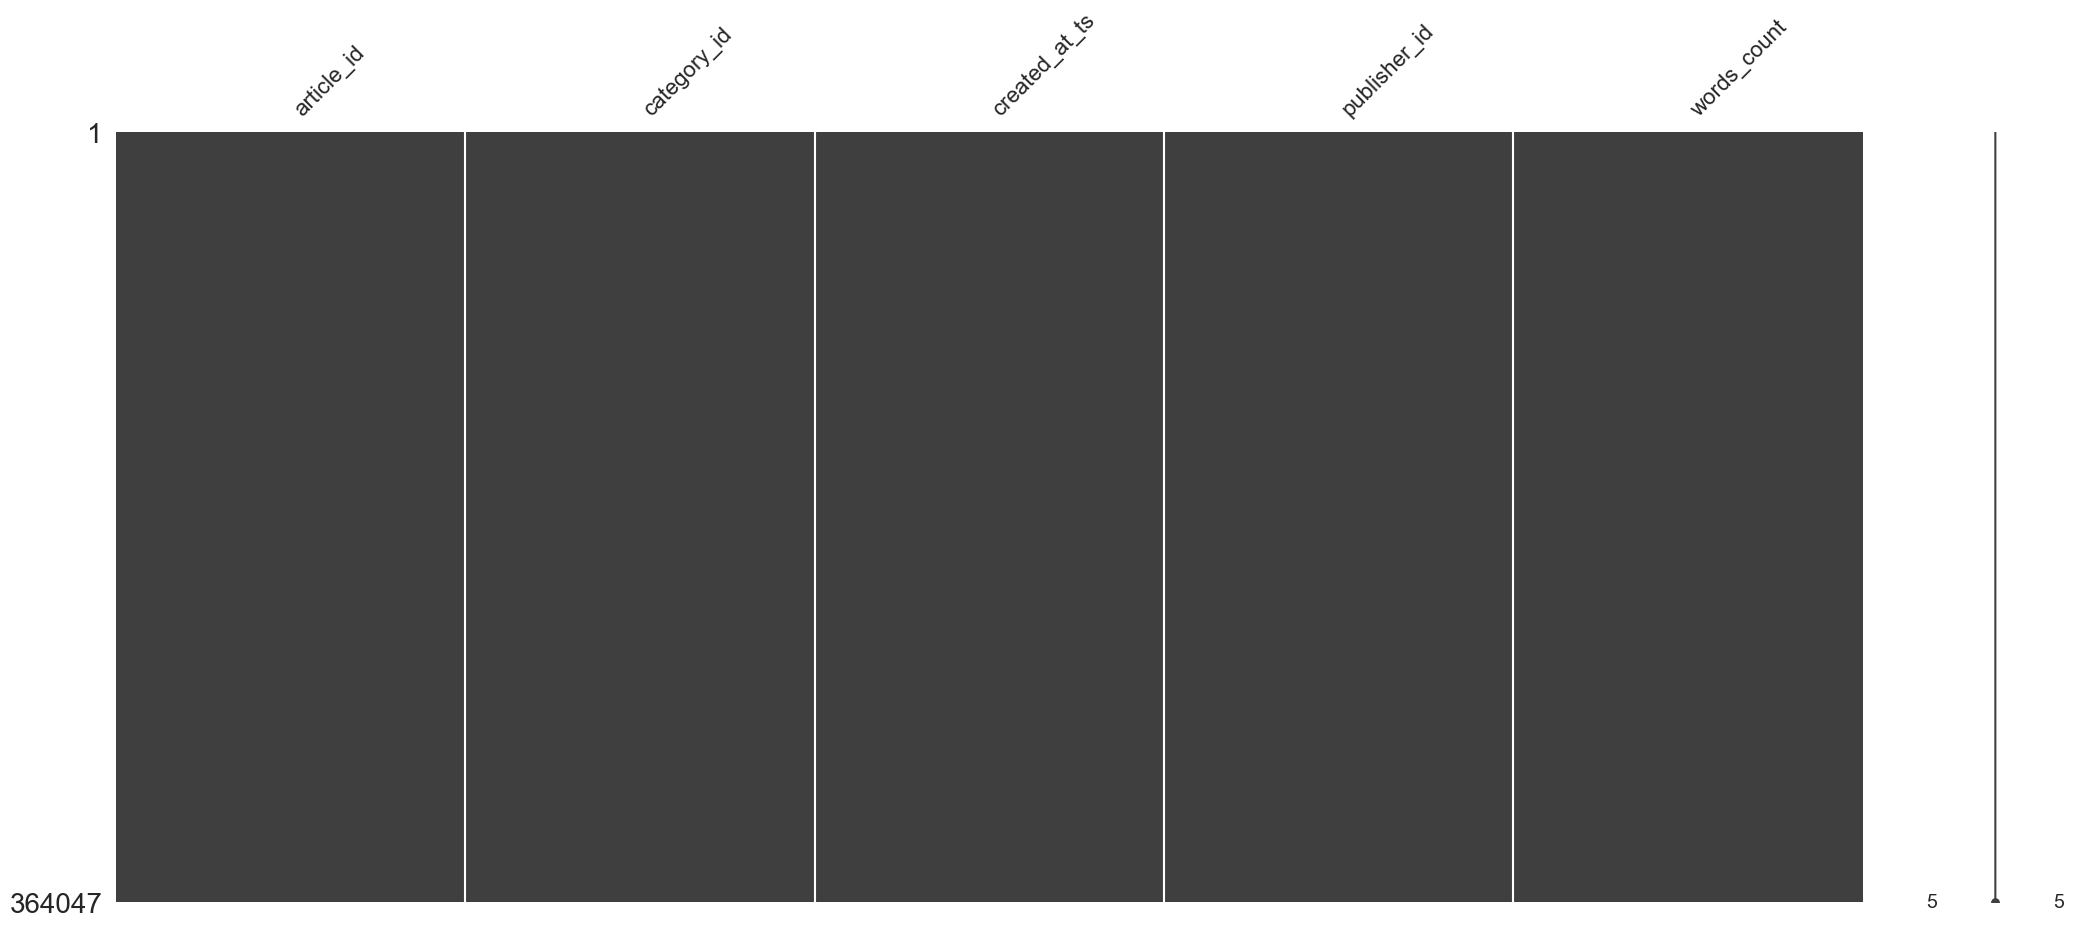

In [296]:
missingno.matrix(articles_df);


In [297]:
articles_df['words_count'].describe()


count    364047.000000
mean        190.897727
std          59.502766
min           0.000000
25%         159.000000
50%         186.000000
75%         218.000000
max        6690.000000
Name: words_count, dtype: float64

In [298]:
articles_df['article_id'].describe()


count    364047.000000
mean     182023.000000
std      105091.461061
min           0.000000
25%       91011.500000
50%      182023.000000
75%      273034.500000
max      364046.000000
Name: article_id, dtype: float64

In [299]:
articles_df['category_id'].describe()


count    364047.000000
mean        283.108239
std         136.723470
min           0.000000
25%         199.000000
50%         301.000000
75%         399.000000
max         460.000000
Name: category_id, dtype: float64

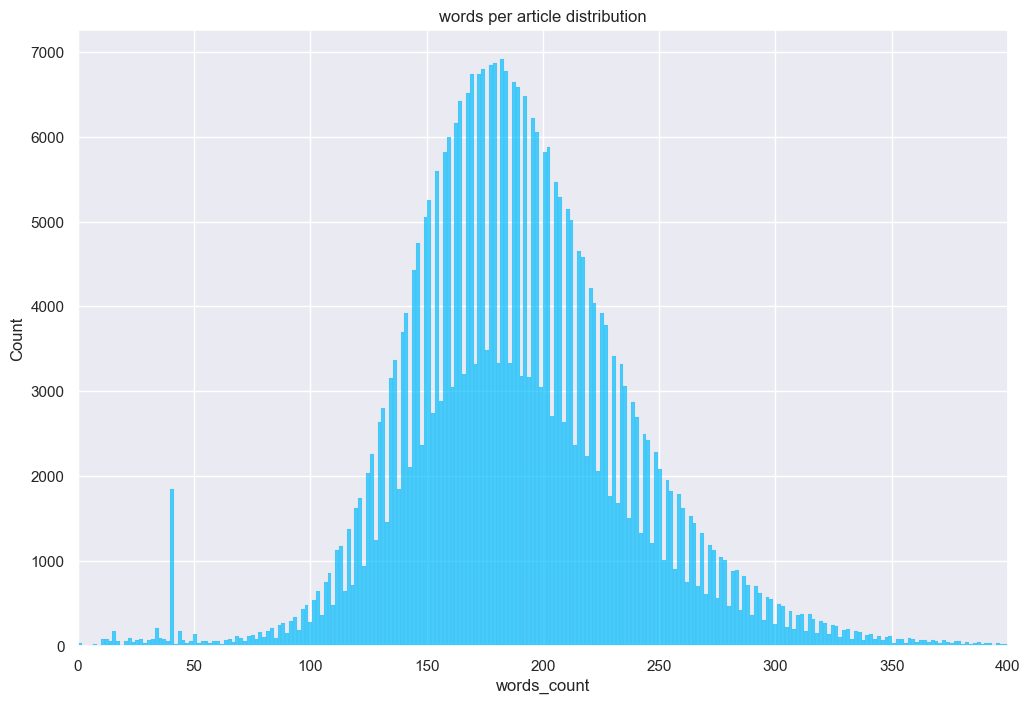

In [300]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.histplot(articles_df['words_count'],
            color="deepskyblue",
            edgecolor="black",
            alpha=0.7,
            ax=ax)

plt.xlim([0,400])
plt.title('words per article distribution');
plt.show()

In [301]:
print(f'Empty article(s) : {articles_df[articles_df["words_count"] == 0].count()[0]}')


Empty article(s) : 35


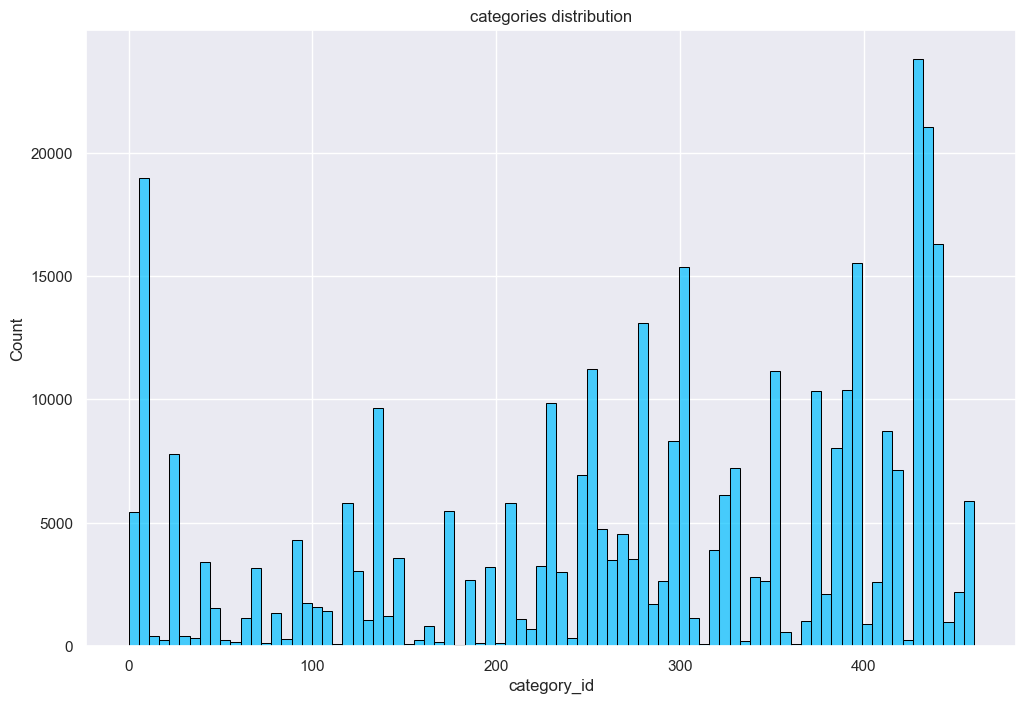

In [302]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.histplot(articles_df['category_id'],
            color="deepskyblue",
            edgecolor="black",
            alpha=0.7,
            ax=ax)

plt.title('categories distribution');
plt.show()

In [303]:
# Check unique values per column
print('=== Unique values of metadata dataframes ===')
print('=============================================================')
for col in articles_df.columns:
    print(col, ' :', articles_df[col].nunique())

=== Unique values of metadata dataframes ===
article_id  : 364047
category_id  : 461
created_at_ts  : 359552
publisher_id  : 1
words_count  : 866


## EDA sur les fichiers présents dans le dossier clicks 

In [304]:
src_path = Path()

In [305]:
# Path to the clicks files
click_path = Path('./clicks/clicks')

In [306]:
# Create filename list and empty list
click_filelist = sorted(os.listdir(click_path))
click_list = []

# Iterate over files in folder and list
for i in range(0, len(click_filelist)):
    # Read CSV file (i order)
    temp = pd.read_csv(click_path / click_filelist[i])
    # Create a specific column to track the file number
    temp['filename'] = i
    # Append to list
    click_list.append(temp)

# Concate in unique DF
clicks = pd.concat(click_list, axis=0, ignore_index=True)

# Rename columns
clicks.rename(columns={'click_article_id':'article_id'}, inplace=True)

# Convert date string to datetime
date2convert = ['session_start', 'click_timestamp']
for col in date2convert:
    clicks[col] = pd.to_datetime(clicks[col], unit='ms')

# Display shape and 5 first rows
print('Données de clics: ', clicks.shape)
clicks.head()

Données de clics:  (2988181, 13)


,user_id,session_id,session_start,session_size,article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,filename
0,0,1506825423271737,2017-10-01 02:37:03,2,157541,2017-10-01 03:00:28.020,4,3,20,1,20,2,0
1,0,1506825423271737,2017-10-01 02:37:03,2,68866,2017-10-01 03:00:58.020,4,3,20,1,20,2,0
2,1,1506825426267738,2017-10-01 02:37:06,2,235840,2017-10-01 03:03:37.951,4,1,17,1,16,2,0
3,1,1506825426267738,2017-10-01 02:37:06,2,96663,2017-10-01 03:04:07.951,4,1,17,1,16,2,0
4,2,1506825435299739,2017-10-01 02:37:15,2,119592,2017-10-01 03:04:50.575,4,1,17,1,24,2,0


In [307]:
# Check unique values per column
print('=== Unique values of interactions dataframe ===')
print('=================================================================')
for col in clicks.columns:
    print(col, ' :', clicks[col].nunique())

=== Unique values of interactions dataframe ===
user_id  : 322897
session_id  : 1048594
session_start  : 646874
session_size  : 72
article_id  : 46033
click_timestamp  : 2983198
click_environment  : 3
click_deviceGroup  : 5
click_os  : 8
click_country  : 11
click_region  : 28
click_referrer_type  : 7
filename  : 384


In [308]:
PATH_CLICK_SAMPLE_DATA = "clicks_sample.csv"
clicks_samp_df = pd.read_csv(PATH_CLICK_SAMPLE_DATA)

In [309]:
clicks_samp_df.head(5)

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2


In [310]:
clicks_samp_df.shape

(1883, 12)

In [311]:
[print(x) for x in clicks_samp_df.columns];

user_id
session_id
session_start
session_size
click_article_id
click_timestamp
click_environment
click_deviceGroup
click_os
click_country
click_region
click_referrer_type


In [312]:
%%time

CLICK_FILES_PATH = "./clicks/clicks/"

#Get all .csv contain in clicks folder
click_files = [CLICK_FILES_PATH + x for x in os.listdir(CLICK_FILES_PATH)];

#Sort all files PATH contain in list.
click_files.sort()

#Check if all files are present.
print("Total PATH contain in list : ", len(click_files))

list_click_file_to_df = [pd.read_csv(x, index_col=None, header=0) for x in click_files];

#Remove unused columns
list_click_file_to_df_cleaned = [x.drop(columns = ['session_id',
                                                   'session_start',
                                                   'session_size',
                                                   'click_timestamp',
                                                   'click_environment',
                                                   'click_deviceGroup',
                                                   'click_os',
                                                   'click_country',
                                                   'click_region',
                                                   'click_referrer_type']) for x in list_click_file_to_df]

all_clicks_df = pd.concat(list_click_file_to_df_cleaned, axis=0, ignore_index=True)

print(f"DataFrame shape : {all_clicks_df.shape}")

Total PATH contain in list :  385
DataFrame shape : (2988181, 2)
CPU times: total: 3.25 s
Wall time: 4.81 s


In [313]:
all_clicks_df.head()

,user_id,click_article_id
0,0,157541
1,0,68866
2,1,235840
3,1,96663
4,2,119592


# technique 1

# Content-based : by category

## préparation des données

## Combinons tous les fichiers de clics en un seul gros fichier


In [314]:
%%time

if not os.path.exists('clicks.csv'):
    clicks_path = []
    clicks_dir = "./clicks/clicks"

    clicks_path = clicks_path + sorted(
            [
                os.path.join(clicks_dir, fname)
                for fname in os.listdir(clicks_dir)
                if fname.endswith(".csv")
            ]
        )
    print("Number of clicks csv:", len(clicks_path))

    _li = []

    for filename in clicks_path:
        df = pd.read_csv(filename, index_col=None, header=0)
        _li.append(df)

    clicks = pd.concat(_li, axis=0, ignore_index=True)
    clicks.to_csv('clicks.csv')
else:
    clicks= pd.read_csv('clicks.csv')    

CPU times: total: 2.16 s
Wall time: 3.26 s


In [315]:
clicks.head()

,Unnamed: 0,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2


## regroupement de chaque clic sur un article par utilisateur.


In [316]:
df = clicks.groupby('user_id').agg(
    LIST_click_article_id = ('click_article_id', lambda x: list(x)),
)

In [317]:
df.head()

,LIST_click_article_id
user_id,
0,"[157541, 68866, 96755, 313996, 160158, 233470,..."
1,"[235840, 96663, 59758, 160474, 285719, 156723,..."
2,"[119592, 30970, 30760, 209122]"
3,"[236065, 236294, 234686, 233769, 235665, 23513..."
4,"[48915, 44488, 195887, 195084, 63307, 336499, ..."


In [318]:
%%time
#Code need optimization

if not os.path.exists('df.csv'):
    pbar = progressbar.ProgressBar(widgets=[progressbar.Percentage(), progressbar.Bar()], maxval=len(df)).start()
    
    df['categories'] = ''

    for index, row in df.iterrows():
        pbar.update(index)
        _list_row = []
        for article in row.LIST_click_article_id:
            _list_row.append(articles_metadata[articles_metadata.article_id == article].category_id.values[0])
        df.loc[index]['categories']=_list_row
    df.to_csv('df.csv')
    pbar.finish()
else:
    df= pd.read_csv('df.csv')

CPU times: total: 609 ms
Wall time: 864 ms


In [319]:
df.head()

,user_id,LIST_click_article_id,categories
0,0,"[157541, 68866, 96755, 313996, 160158, 233470,...","[281, 136, 209, 431, 281, 375, 186, 186]"
1,1,"[235840, 96663, 59758, 160474, 285719, 156723,...","[375, 209, 123, 281, 412, 281, 331, 412, 435, ..."
2,2,"[119592, 30970, 30760, 209122]","[247, 26, 26, 332]"
3,3,"[236065, 236294, 234686, 233769, 235665, 23513...","[375, 375, 375, 375, 375, 375, 281, 375, 375, ..."
4,4,"[48915, 44488, 195887, 195084, 63307, 336499, ...","[92, 81, 317, 317, 132, 437, 399]"


## Calcul des clics par utilisateur

In [320]:
def inputUserRatings(userId):
    _matrix = pd.DataFrame(columns=['click'])
    _row = df.loc[userId]['categories']
    _row = _row.replace('[', '').replace(']', '').replace(',', '').split()
    
    for index, val in pd.Series(_row).value_counts().items():
        _matrix.loc[index] = int(val)
         
    _matrix['click_norm'] = _matrix.apply(lambda x : x / _matrix['click'].max())
    _matrix = _matrix.reset_index()
    _matrix = _matrix.rename(columns={"index": "category_id"})
    _matrix['category_id'] = _matrix['category_id'].astype(int)
    
    return _matrix

In [321]:
inputUserRatings(0)

,category_id,click,click_norm
0,281,2,1.0
1,186,2,1.0
2,136,1,0.5
3,209,1,0.5
4,431,1,0.5
5,375,1,0.5


## Recommandation des livres parmi les 364 047 livres disponibles en fonction de l'identifiant de catégorie préféré

In [322]:
articles_matrix = articles_df.loc[:, ['article_id', 'category_id']]
display(articles_matrix.dtypes)

article_id     int64
category_id    int64
dtype: object

In [323]:
articles_matrix.shape

(364047, 2)

In [324]:
def recommend5(userId, articles_matrix):
    _input_user_ratings = inputUserRatings(userId)
    _articles_matrix = articles_matrix
    
    # Création du DataFrame _weighed_articles_matrix
    _weighed_articles_matrix = pd.DataFrame(columns=['article_id', 'category_id', 'weight'])
    _weighed_articles_matrix['article_id'] = _articles_matrix['article_id']
    _weighed_articles_matrix['category_id'] = _articles_matrix['category_id']

    # Calcul des poids pour chaque catégorie
    _weighed_articles_matrix['weight'] = _weighed_articles_matrix['category_id'].apply(lambda x :
                                                                                        0                                                                                           
                                                                                       if(_input_user_ratings.loc[_input_user_ratings['category_id'] == x].empty)
                                                                                       else
                                                                                        _input_user_ratings.loc[_input_user_ratings['category_id'] == x].click_norm.values[0]
                                                                                      )
    
    # Filtrage, tri et retour des 5 premiers article_id
    return _weighed_articles_matrix[_weighed_articles_matrix['weight'] > 0] \
               .sort_values(by=['weight'], ascending=False) \
               .head(5)['article_id'].tolist()

## resultat de recommandation pour user 1

In [325]:
%%time
res_technique1 = recommend5(1 , articles_matrix)
res_technique1

CPU times: total: 1min 1s
Wall time: 1min 23s


[158212, 279260, 279246, 279247, 279248]

## cela fonctionne mais cela prend trop de temps. 

- Environ 3 minutes par utilisateur. 
- Ne fonctionne que si l'utilisateur a peu d'interactions. 

## **Nous utiliserons le résultat de cet algorithme pour comparer avec les algorithmes suivants.**

# technique 2

## Content-based recommendation system avec le fichier articles embedding "embeddings pickle"

## Methode 1

In [326]:
pickle = pd.read_pickle('articles_embeddings.pickle')
pickle.shape

(364047, 250)

In [327]:
def find_top_n_indices(data, top=5):
    indexed = enumerate(data)
    sorted_data = sorted(indexed, 
                         key=itemgetter(1), 
                         reverse=True) 
    return [d[0] for d in sorted_data[:top]] 

In [328]:
def recommendFromArticle(article_id, top):
    score = []
    for i in range(0, len(pickle)):
        if(article_id != i):
            cos_sim = np.dot(pickle[article_id], pickle[i])/(np.linalg.norm(pickle[article_id])*np.linalg.norm(pickle[i]))
            score.append(cos_sim)
    
    _best_scores = find_top_n_indices(score, top)
            
    return _best_scores

## resultat de recommandation pour article 1

In [329]:
res_technique2_methode1 = recommendFromArticle(1, 5)
res_technique2_methode1

[7209, 7125, 303002, 244379, 109452]

## Methode 2 Creating a linear kernel

### en raison de l'utilisation de la memoire nous sommes contraints d'utiliser un echantillon

In [330]:
cosine_similarities = linear_kernel(pickle[:50000], pickle[:50000]) 
cosine_similarities.shape

(50000, 50000)

In [331]:
titles = articles_df['article_id']
indices = pd.Series(articles_df.index, index=articles_df['article_id'])

In [332]:
def simScores(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    
    return sim_scores
    print(sim_scores)

def predictWSimScores(userId):
    _input_user_ratings = inputUserRatings(userId)
    _result = []
    for index, row in _input_user_ratings.iterrows():
        _x = simScores(row.category_id)
        for i in range(1, int(row.click)):
            _result = _result + _x
    df_result = pd.DataFrame(_result, columns =['category_id', 'score']).groupby('category_id').mean().sort_values('score',ascending=False).head(5)
    return df_result

In [333]:
df.head()

,user_id,LIST_click_article_id,categories
0,0,"[157541, 68866, 96755, 313996, 160158, 233470,...","[281, 136, 209, 431, 281, 375, 186, 186]"
1,1,"[235840, 96663, 59758, 160474, 285719, 156723,...","[375, 209, 123, 281, 412, 281, 331, 412, 435, ..."
2,2,"[119592, 30970, 30760, 209122]","[247, 26, 26, 332]"
3,3,"[236065, 236294, 234686, 233769, 235665, 23513...","[375, 375, 375, 375, 375, 375, 281, 375, 375, ..."
4,4,"[48915, 44488, 195887, 195084, 63307, 336499, ...","[92, 81, 317, 317, 132, 437, 399]"


## resultat de recommandation pour user 1

In [335]:
res_technique2_methode2 = predictWSimScores(1)
res_technique2_methode2

,score
category_id,
1386,67.031746
1218,66.698814
1121,66.558762
1274,66.530884
375,66.304886


In [336]:
res_technique2_methode2.index.to_list()

[1386, 1218, 1121, 1274, 375]

# technique 3: SVD (Collaborative filtering)

In [338]:
#Create a map to convert article_id to category
dict_article_categories = articles_df.set_index('article_id')['category_id'].to_dict()

#Get Categorie associate for each article
all_clicks_df['category_id'] = all_clicks_df['click_article_id'].map(dict_article_categories).astype(int)
all_clicks_df['total_click'] = all_clicks_df.groupby(['user_id'])['click_article_id'].transform('count')
all_clicks_df['total_click_by_category_id'] = all_clicks_df.groupby(['user_id','category_id'])['click_article_id'].transform('count')
all_clicks_df['rating'] = all_clicks_df['total_click_by_category_id'] / all_clicks_df['total_click']

print(f'Shape before dropping duplicate : {all_clicks_df.shape}')
all_clicks_df = all_clicks_df.drop(['click_article_id'], axis=1)
all_clicks_df = all_clicks_df.drop_duplicates()
print(f'Shape after dropping duplicate : {all_clicks_df.shape}')

Shape before dropping duplicate : (2988181, 6)
Shape after dropping duplicate : (1882302, 5)


In [339]:
#Remove not used columns
all_clicks_df = all_clicks_df.drop(['total_click', 'total_click_by_category_id'], axis=1)

all_clicks_df[all_clicks_df['user_id'] == 0]

,user_id,category_id,rating
0,0,281,0.250
1,0,136,0.125
1287361,0,209,0.125
1287362,0,431,0.125
1352198,0,375,0.125
1535240,0,186,0.250


In [340]:
#keep 40 000 users to build our model.
df_rating = all_clicks_df[all_clicks_df['user_id'] < 40000]
print(f'size of our sample : {df_rating.shape}')

size of our sample : (404149, 3)


In [341]:
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(0, 1))

#Split our Dataframe 75% train / 25% test
data = Dataset.load_from_df(df_rating[['user_id', 'category_id', 'rating']], reader)
train_set, test_set = train_test_split(data, test_size=.25)
print(f'Size of test set : {len(test_set)}')
print(f'type of train_set : {type(train_set)}')

Size of test set : 101038
type of train_set : <class 'surprise.trainset.Trainset'>


## entrainement du Model

In [342]:
%%time

model = SVD().fit(train_set)

CPU times: total: 5.03 s
Wall time: 8.87 s


##  Resultats

In [343]:
predict = model.test(test_set)

#Print our Results
rmse_svd = accuracy.rmse(predict)
mse_svd = accuracy.mse(predict)
mae_svd = accuracy.mae(predict);

print(f'Prediction rating for User 0 with cat 281 : {model.predict(0, 281).est}')
print(f'Current rating : {df_rating[(df_rating["user_id"] == 0) & (df_rating["category_id"] == 281)]["rating"].values}')

RMSE: 0.1984
MSE: 0.0394
MAE:  0.1574
Prediction rating for User 0 with cat 281 : 0.6040235298860932
Current rating : [0.25]


## Predictions avec test set

In [344]:
#Function from https://github.com/NicolasHug/Surprise/blob/master/examples/top_n_recommendations.py
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.
    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.
    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [345]:
top_n = get_top_n(predict, n=10)

In [346]:
#Make simple recommendation for user.
def make_recommendation(user_ID, top_n, df_rating, articles_df):
    """Return a list of recommanded articles based on the taste of the user and all recommended categories
    Args:
        user_id -> user id used for recommendation
        top_n -> top-N recommendation for each user from a set of predictions
        df_rating -> df used to train our algo
        articles_df -> df with metadata of all articles.
    Returns:
        list(recommanded articles), list(recommanded categories)
    """
    #Get top 5 cat and adding it to our list
    recommanded_cat = [iid for iid, _ in top_n[user_ID]]
    
    #If we don't have any recommandation, use our data.
    if not recommanded_cat:
        recommanded_cat = df[df['user_id'] == user_ID].nlargest(1, ['rating'])['category_id'].values
    
    #Select 5 randoms articles for each recommanded cat.
    random_articles_by_cat = [articles_df[articles_df['category_id'] == x]['article_id'].sample(5).values for x in recommanded_cat]
    
    #Select one of the recommanded cat and return 5 articles.
    rand_category = random.sample(random_articles_by_cat, 1)
    
    return rand_category[0], recommanded_cat

## resultat de recommandation pour user 1

In [347]:
res_technique3, categories = make_recommendation(1, top_n, df_rating, articles_df)
print(f'recommanded categories for user_id[1] : {categories}')
print(f'recommanded articles for user_id[1] : {res_technique3}')

recommanded categories for user_id[1] : [331, 375]
recommanded articles for user_id[1] : [205348 204365 205514 206952 207213]


# technique 4: KNNWithMeans (Collaborative filtering)

## entrainement du Model

In [348]:
%%time 

# To use item-based cosine similarity
sim_options = {
    "name": "cosine",
    "user_based": False,  # Compute similarities between items
}

model = KNNWithMeans(sim_options=sim_options).fit(train_set)

Computing the cosine similarity matrix...
Done computing similarity matrix.
CPU times: total: 281 ms
Wall time: 873 ms


##  Resultats

In [349]:
predict = model.test(test_set)

#Print our Results
rmse_KNNWithMeans = accuracy.rmse(predict)
mse_KNNWithMeans = accuracy.mse(predict)
mae_KNNWithMeans = accuracy.mae(predict);

RMSE: 0.0966
MSE: 0.0093
MAE:  0.0497


In [350]:
print(f'Prediction rating for User 0 with cat 281 : {model.predict(0, 281).est}')
print(f'Current rating : {df_rating[(df_rating["user_id"] == 0) & (df_rating["category_id"] == 281)]["rating"].values}')

Prediction rating for User 0 with cat 281 : 0.2658465045877812
Current rating : [0.25]


##  Prediction avec testSet

In [351]:
top_n = get_top_n(predict, n=10)

## resultat de recommandation pour user 1

In [352]:
res_technique4, categories = make_recommendation(1, top_n, df_rating, articles_df)

print(f'recommanded categories for user_id[1] : {categories}')
print(f'recommanded articles for user_id[1] : {res_technique4}')

recommanded categories for user_id[1] : [331, 375]
recommanded articles for user_id[1] : [205636 206015 207622 204641 206567]


# synthèse des recommandations et métriques pour les differents modèles

In [389]:
# 1. DataFrame des métriques
data_metrics = {
    'Technique/modèle': ['SVD', 'KNNWithMeans'],
    'RMSE': [rmse_svd, rmse_KNNWithMeans],
    'MSE': [mse_svd, mse_KNNWithMeans],
    'MAE': [mae_svd, mae_KNNWithMeans]
}

df_metrics = pd.DataFrame(data_metrics)

In [390]:
print("DataFrame des Métriques :")
df_metrics

DataFrame des Métriques :


,Technique/modèle,RMSE,MSE,MAE
0,SVD,0.198445,0.039381,0.157382
1,KNNWithMeans,0.096647,0.009341,0.049717


### au vu des resultats de ces metriques (les 3 metriques sont plus faibles), nous considerons que le modele KNN est plus le performant.

In [391]:
# 2. DataFrame des recommandations
data_recommendations = {
    'Technique/modèle': ['Content-based', 'Cosine Similarity', 'SVD', 'KNNWithMeans'],
    'Top 5 Livres': [res_technique1, 
                     res_technique2_methode2.index.to_list(),
                     list(res_technique3),
                     list(res_technique4)]
}

df_recommendations = pd.DataFrame(data_recommendations)

In [392]:
print("\nDataFrame des Recommandations :")
df_recommendations


DataFrame des Recommandations :


,Technique/modèle,Top 5 Livres
0,Content-based,"[158212, 279260, 279246, 279247, 279248]"
1,Cosine Similarity,"[1386, 1218, 1121, 1274, 375]"
2,SVD,"[205348, 204365, 205514, 206952, 207213]"
3,KNNWithMeans,"[205636, 206015, 207622, 204641, 206567]"


#  Selection en enregistrement du meilleur model pour le  deployment

In [363]:
import pickle

In [364]:
# Save to file in the current working directory
pkl_filename = "pickle_surprise_model_KNNWithMeansV2.pkl"

with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

In [365]:
# Load from file
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)

# prediction avec le modele enregistré

In [366]:
predict_KNNWithMeans = pickle_model.test(test_set)

In [367]:
top_n = get_top_n(predict_KNNWithMeans, n=10)


In [375]:
recommendation, categories = make_recommendation(1, top_n, df, articles_df)

print(f'recommanded categories for user_id[1] : {categories}')
print(f'recommanded articles for user_id[1] : {recommendation}')

recommanded categories for user_id[1] : [331, 375]
recommanded articles for user_id[1] : [205112 206033 208566 206909 205943]


In [376]:
recommendation, categories = make_recommendation(2, top_n, df, articles_df)

In [378]:
print(f'recommanded categories for user_id[2] : {categories}')
print(f'recommanded articles for user_id[2] : {recommendation}')

recommanded categories for user_id[2] : [332]
recommanded articles for user_id[2] : [208819 208839 208925 209135 208893]
